# Code for training the model

In [1]:
#importing some stuff, not sure what we will need yet

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import random

from tensorflow import keras
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report


In [2]:
#Loading Training CSV data
train=pd.read_csv("sign_mnist_train.csv")
print(train.shape)
train.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
#Loading Testing CSV data
test=pd.read_csv("sign_mnist_test.csv")
print(train.shape)
test.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [4]:
#Next we must seperate the labels from the data
label_train=train["label"]
label_test=test["label"]

img_train=train.drop(['label'],axis=1)
img_test=test.drop(['label'],axis=1)

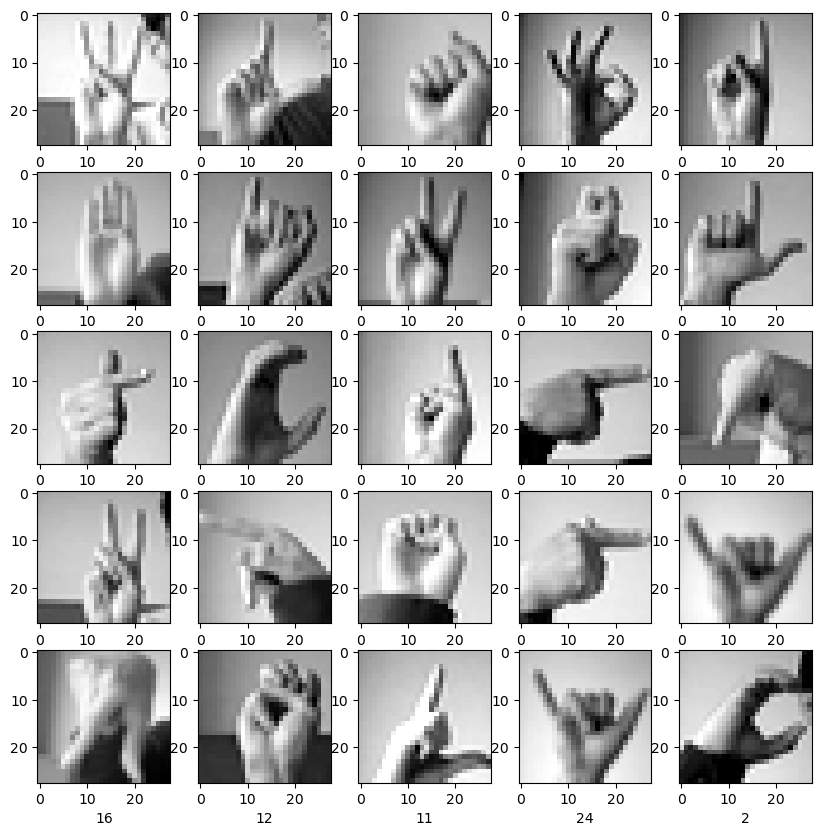

In [5]:
#visualizing what a random image looks like in the dataset to ensure accuracy

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10))

for a in ax.reshape(-1):
    sampImg = random.randint(0,len(img_train.index))
    i=img_train.iloc[sampImg].to_numpy()
    i=i.reshape((28,28))
    a.imshow(i, cmap = 'gray')
    a.set_xlabel(label_train.iloc[sampImg])
plt.show()

#A=0
#B=1
#C=2
#etc

In [6]:
#reshaping the image data into a MNIST type format
train_images = img_train.values.reshape(-1,28,28,1)
test_images = img_test.values.reshape(-1,28,28,1)

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

In [7]:
# fixing label data
labels = to_categorical(label_train, num_classes = 25)
labels_test = to_categorical(label_test, num_classes = 25)


In [8]:
#splitting training data to such that we can use the validation dataset for post model metrics lice confusion matrix
X_train, X_val, Y_train, Y_val = train_test_split(train_images, labels, test_size=0.10, random_state=69)

print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (24709, 28, 28, 1)
x_test shape (2746, 28, 28, 1)
y_train shape (24709, 25)
y_test shape (2746, 25)


In [9]:
#creating more data using image data generator (this will be used late, just setting it up)
datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip=True

)

train_data = datagen.flow(X_train, Y_train, batch_size = 128)
test_data = datagen.flow(X_val, Y_val, batch_size = 128)

In [10]:
# Define the model architecture.
model = tf.keras.models.Sequential([
    layers.Conv2D(100, (5, 5), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    layers.Conv2D(50, (5,5), activation = 'relu', padding = 'same', input_shape = (28,28,1)),
    layers.Conv2D(50, (3,3), activation = 'relu', padding = 'same', input_shape = (28,28,1)),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(10, (5, 5), activation = 'relu', padding = 'same', input_shape = (14, 14, 1)),
    layers.Conv2D(10, (3, 3), activation = 'relu', padding = 'same', input_shape = (14, 14, 1)),
    
    layers.Flatten(),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(25, activation = 'softmax')
])

# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 100)       2600      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 50)        125050    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 50)        22550     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 50)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 10)        12510     
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 10)        910       
                                                        

In [11]:
# compilinga and training the model
model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])



In [12]:
# training model
trained_model = model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5


194/194 [==============================] - 105s 537ms/step - loss: 2.5658 - accuracy: 0.2259 - val_loss: 1.2698 - val_accuracy: 0.5998
Epoch 2/5
194/194 [==============================] - 102s 524ms/step - loss: 0.6982 - accuracy: 0.7760 - val_loss: 0.2464 - val_accuracy: 0.9221
Epoch 3/5
194/194 [==============================] - 104s 537ms/step - loss: 0.1949 - accuracy: 0.9397 - val_loss: 0.1213 - val_accuracy: 0.9603
Epoch 4/5
194/194 [==============================] - 100s 515ms/step - loss: 0.0754 - accuracy: 0.9750 - val_loss: 0.0631 - val_accuracy: 0.9807
Epoch 5/5
194/194 [==============================] - 101s 521ms/step - loss: 0.0495 - accuracy: 0.9853 - val_loss: 0.0153 - val_accuracy: 0.9942


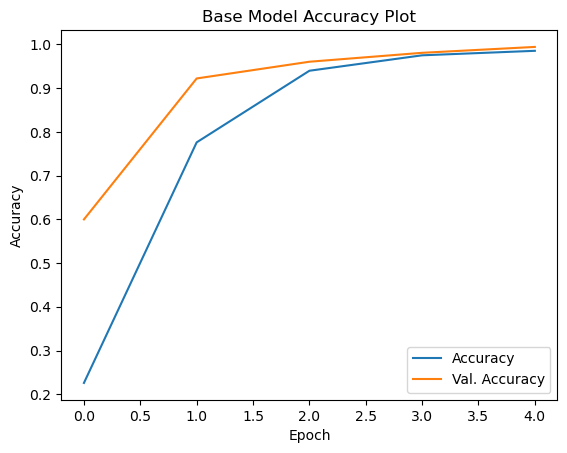

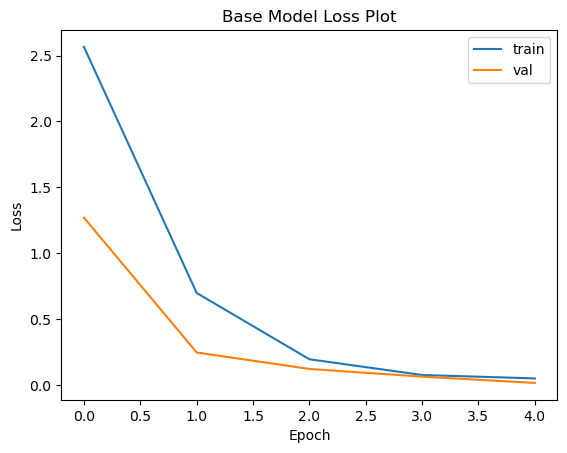

In [13]:
#plotting results over the epocs
plt.plot(trained_model.history['accuracy'], label='Accuracy')
plt.plot(trained_model.history['val_accuracy'], label = 'Val. Accuracy')
plt.title('Base Model Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Base Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [14]:
#saving model

model.save('trained_signLang_model_20240322.h5')

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# defining some functions to be used later

#model size function
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

#clustering function
def cluster_model(model, num_clust, train_images, train_labels, epochs): 
    # ---------- Defining clustering params ----------
    cluster_weights = tfmot.clustering.keras.cluster_weights

    clustering_params = {
    'number_of_clusters': num_clust,
    'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS,
    'preserve_sparsity': True
    }

    # -------  Clustering --------------
    clustered_model = cluster_weights(model, **clustering_params)

    clustered_model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

    clustered_model.fit(train_images, train_labels, epochs = epochs, validation_split =0.1)

    stripped_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

    # ------- Printing Summary ----------
    clustered_model.summary()

    return clustered_model, stripped_clustered_model

def iterative_prune_model(model, initial_sparsity, final_sparsity, begin_step, end_step, train_images, train_labels, epochs):
  # --------- Pruning Variable Setup ---------
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  # ------------- Pruning Model -------------
  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  pruned_model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images, train_labels, epochs=epochs, validation_split=0.1,
                    callbacks=callbacks)

  # -------- Strip Pruning -------------
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  # ------- Printing Summaries ----------
  pruned_model.summary()
  stripped_pruned_model.summary()

  return pruned_model, stripped_pruned_model



In [16]:
#getting baseline numbers to understand model.
model = tf.keras.models.load_model('trained_signLang_model.h5')

# Evaluate prediction accuracy
test_loss, test_acc = model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_data)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size('trained_signLang_model.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 1s - loss: 0.3149 - accuracy: 0.9083 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 4ms/step
Model Size: 429885.00 bytes
Model Accuracy: 90.8254325389862 %
Inference Time is 0.051577307961203835 s


In [17]:
# first thing we will do to reduce model size is prune it

# load model
loaded_model = tf.keras.models.load_model('trained_signLang_model.h5')

#variables that are to be manipulated
initial_sparsity = 0
final_sparsity = 0.9
begin_step = 0
end_step = 300
epochs = 2

#function call
pruned_model, stripped_pruned_model = iterative_prune_model(loaded_model, initial_sparsity, final_sparsity, 
                                                            begin_step, end_step, train_images, 
                                                            labels, epochs)


Epoch 1/2
773/773 [==============================] - 14s 15ms/step - loss: 0.9673 - accuracy: 0.7537 - val_loss: 0.6288 - val_accuracy: 0.8125
Epoch 2/2
773/773 [==============================] - 12s 15ms/step - loss: 0.3850 - accuracy: 0.8945 - val_loss: 0.2545 - val_accuracy: 0.9381
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        2552      
 _14 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_12 (PruneLowMagnit                                      
 ude)                                                            
                                                                 
 prune_low_magnitude_conv2d  (None, 14, 14, 10)        9012      
 _15 (PruneLowMagnitude)        

In [18]:
#saving model
stripped_pruned_model.save(f'stripPruned_signLang_model_{final_sparsity}.h5')

In [19]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

conv2d_14/kernel:0: 90.00% sparsity  (1125/1250)
conv2d_15/kernel:0: 90.00% sparsity  (4050/4500)
dense_14/kernel:0: 90.00% sparsity  (44100/49000)
dense_15/kernel:0: 90.00% sparsity  (2250/2500)


In [20]:
#getting baseline numbers to understand model.
s_model = pruned_model
# Evaluate prediction accuracy
test_loss, test_acc = s_model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = s_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size(f'stripPruned_signLang_model_{final_sparsity}.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 1s - loss: 0.4382 - accuracy: 0.8424 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 5ms/step
Model Size: 47505.00 bytes
Model Accuracy: 84.24428105354309 %
Inference Time is 0.00017146068914469833 s


In [21]:
#clustering the pruned model and perserving its sparcity

model = tf.keras.models.load_model(f'stripPruned_signLang_model_{final_sparsity}.h5')

#defining some variables
num_clust = 16

#Function call
clustered_model, strip_clust_model = cluster_model(model, num_clust, train_images, labels, epochs)

strip_clust_model.save(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5')


Epoch 1/2
773/773 [==============================] - 14s 17ms/step - loss: 0.1989 - accuracy: 0.9457 - val_loss: 0.1698 - val_accuracy: 0.9501
Epoch 2/2
773/773 [==============================] - 13s 17ms/step - loss: 0.1317 - accuracy: 0.9635 - val_loss: 0.1099 - val_accuracy: 0.9672
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2566      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 14, 10)        9026      
 Weights)                                                        
                                

In [22]:
#getting baseline numbers to understand model.
c_model = clustered_model
# Evaluate prediction accuracy
test_loss, test_acc = c_model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = c_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 1s - loss: 0.3551 - accuracy: 0.8758 - 1s/epoch - 6ms/step
225/225 [==============================] - 1s 6ms/step
Model Size: 14616.00 bytes
Model Accuracy: 87.57668733596802 %
Inference Time is 0.00022278038802521892 s


# Evaluating different combinations

In these graphs we will look at how different pruning and clustering levels affect inference time, size and accuracy to help us determine the final model

In [23]:
from pandas import DataFrame as df

prunes = [0.1,0.5,0.75,0.9,0.95]
clusters = [4,8,16,32]
metrics = df(columns=['%Prune','Clusters','Accuracy','Size',"Time"])

# load model
loaded_model = tf.keras.models.load_model('trained_signLang_model.h5')

for i in prunes:
    # ------------- Prunining --------------------
    #variables that are to be manipulated
    initial_sparsity = 0
    final_sparsity = i
    begin_step = 0
    end_step = 300
    epochs = 2

    #function call
    pruned_model, stripped_pruned_model = iterative_prune_model(loaded_model, initial_sparsity, final_sparsity, 
                                                                    begin_step, end_step, train_images, 
                                                                    labels, epochs)
        
    #saving model
    stripped_pruned_model.save(f'stripPruned_signLang_model_{final_sparsity}.h5')

    for j in clusters:
        
        # ------------- Clustering --------------------
        
        #clustering the pruned model and perserving its sparcity

        model = tf.keras.models.load_model(f'stripPruned_signLang_model_{final_sparsity}.h5')

        #defining some variables
        num_clust = j

        #Function call
        clustered_model, strip_clust_model = cluster_model(model, num_clust, train_images, labels, epochs)

        strip_clust_model.save(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5')

        # ----------------- Evaluating -----------------
        c_model = clustered_model

        # Evaluate prediction accuracy
        test_loss, test_acc = c_model.evaluate(test_images, labels_test, verbose=2)

        # Evaluate Inference Time
        startTime = time.time()
        prediction = c_model.predict(test_images)
        executionTime = (time.time() - startTime)/len(test_images)

        
        metrics.loc[len(metrics)]=[str(i),str(j),test_acc*100,
                                   get_gzipped_model_size(f'stripClust_signLang_model_{final_sparsity}_{num_clust}.h5'),
                                   executionTime]

Epoch 1/2
773/773 [==============================] - 14s 16ms/step - loss: 0.0971 - accuracy: 0.9710 - val_loss: 0.1847 - val_accuracy: 0.9341
Epoch 2/2
773/773 [==============================] - 12s 15ms/step - loss: 0.0143 - accuracy: 0.9965 - val_loss: 0.0100 - val_accuracy: 0.9993
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        2552      
 _14 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_12 (PruneLowMagnit                                      
 ude)                                                            
                                                                 
 prune_low_magnitude_conv2d  (None, 14, 14, 10)        9012      
 _15 (PruneLowMagnitude)        

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 13s 16ms/step - loss: 0.1685 - accuracy: 0.9708 - val_loss: 0.0679 - val_accuracy: 0.9741
Epoch 2/2
773/773 [==============================] - 12s 16ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.0056 - val_accuracy: 0.9993
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2554      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 14, 10)        9014      
 Weights)                                                        
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2543 - accuracy: 0.9389 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 5ms/step
Epoch 1/2
773/773 [==============================] - 14s 17ms/step - loss: 0.0109 - accuracy: 0.9974 - val_loss: 0.0034 - val_accuracy: 0.9985
Epoch 2/2
773/773 [==============================] - 13s 17ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 8.5479e-04 - val_accuracy: 1.0000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2566      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2068 - accuracy: 0.9558 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 6ms/step
Epoch 1/2
773/773 [==============================] - 15s 18ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 2.2332e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 14s 18ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 8.0838e-04 - val_accuracy: 0.9996
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2582      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (No

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2191 - accuracy: 0.9465 - 1s/epoch - 6ms/step
225/225 [==============================] - 2s 6ms/step
Epoch 1/2
773/773 [==============================] - 14s 16ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 6.9969e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 12s 16ms/step - loss: 1.4323e-04 - accuracy: 1.0000 - val_loss: 3.4135e-05 - val_accuracy: 1.0000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        2552      
 _14 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_12 (PruneLowMagnit                                      
 ude)                                                            
                            

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 13s 16ms/step - loss: 0.0150 - accuracy: 0.9962 - val_loss: 0.0441 - val_accuracy: 0.9869
Epoch 2/2
773/773 [==============================] - 13s 16ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.0070 - val_accuracy: 0.9978
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2554      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 14, 10)        9014      
 Weights)                                                        
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2695 - accuracy: 0.9448 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 5ms/step
Epoch 1/2
773/773 [==============================] - 14s 17ms/step - loss: 2.5618e-04 - accuracy: 1.0000 - val_loss: 3.7170e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 13s 17ms/step - loss: 5.1605e-04 - accuracy: 0.9998 - val_loss: 1.0312e-04 - val_accuracy: 1.0000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2566      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Clus

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2786 - accuracy: 0.9463 - 1s/epoch - 6ms/step
225/225 [==============================] - 1s 6ms/step
Epoch 1/2
773/773 [==============================] - 14s 18ms/step - loss: 6.1717e-05 - accuracy: 1.0000 - val_loss: 3.7518e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 13s 17ms/step - loss: 8.0716e-05 - accuracy: 1.0000 - val_loss: 1.7521e-05 - val_accuracy: 1.0000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2582      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Clus

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2146 - accuracy: 0.9650 - 1s/epoch - 6ms/step
225/225 [==============================] - 2s 6ms/step
Epoch 1/2
773/773 [==============================] - 14s 16ms/step - loss: 0.0297 - accuracy: 0.9943 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 12s 15ms/step - loss: 9.0954e-04 - accuracy: 1.0000 - val_loss: 1.9091e-04 - val_accuracy: 1.0000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        2552      
 _14 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_12 (PruneLowMagnit                                      
 ude)                                                            
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 13s 16ms/step - loss: 0.0165 - accuracy: 0.9970 - val_loss: 5.4477e-04 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 12s 16ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0122 - val_accuracy: 0.9960
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2554      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 14, 10)        9014      
 Weights)                                                        
                            

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.3234 - accuracy: 0.9385 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 6ms/step
Epoch 1/2
773/773 [==============================] - 14s 17ms/step - loss: 4.0755e-04 - accuracy: 0.9999 - val_loss: 8.0829e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 13s 17ms/step - loss: 3.0298e-04 - accuracy: 0.9999 - val_loss: 1.2585e-04 - val_accuracy: 1.0000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2566      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Clus

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2096 - accuracy: 0.9508 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 6ms/step
Epoch 1/2
773/773 [==============================] - 15s 18ms/step - loss: 1.2359e-04 - accuracy: 1.0000 - val_loss: 5.4337e-05 - val_accuracy: 1.0000
Epoch 2/2
773/773 [==============================] - 14s 18ms/step - loss: 1.2588e-04 - accuracy: 1.0000 - val_loss: 6.7850e-05 - val_accuracy: 1.0000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2582      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Clus

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.2246 - accuracy: 0.9572 - 1s/epoch - 6ms/step
225/225 [==============================] - 2s 6ms/step
Epoch 1/2
773/773 [==============================] - 14s 15ms/step - loss: 0.7122 - accuracy: 0.8545 - val_loss: 0.2154 - val_accuracy: 0.9585
Epoch 2/2
773/773 [==============================] - 12s 15ms/step - loss: 0.1030 - accuracy: 0.9857 - val_loss: 0.0452 - val_accuracy: 0.9938
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        2552      
 _14 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_12 (PruneLowMagnit                                      
 ude)                                                            
                                        

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 13s 16ms/step - loss: 0.2708 - accuracy: 0.9247 - val_loss: 0.0935 - val_accuracy: 0.9785
Epoch 2/2
773/773 [==============================] - 12s 16ms/step - loss: 0.0986 - accuracy: 0.9698 - val_loss: 0.0699 - val_accuracy: 0.9800
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2554      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 14, 10)        9014      
 Weights)                                                        
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.4009 - accuracy: 0.8841 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 5ms/step
Epoch 1/2
773/773 [==============================] - 14s 17ms/step - loss: 0.0320 - accuracy: 0.9968 - val_loss: 0.0161 - val_accuracy: 0.9993
Epoch 2/2
773/773 [==============================] - 13s 16ms/step - loss: 0.0135 - accuracy: 0.9984 - val_loss: 0.0212 - val_accuracy: 0.9916
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2566      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.3274 - accuracy: 0.9161 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 6ms/step
Epoch 1/2
773/773 [==============================] - 14s 18ms/step - loss: 0.0270 - accuracy: 0.9978 - val_loss: 0.0167 - val_accuracy: 0.9978
Epoch 2/2
773/773 [==============================] - 13s 17ms/step - loss: 0.0093 - accuracy: 0.9993 - val_loss: 0.0056 - val_accuracy: 0.9993
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2582      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.3086 - accuracy: 0.9299 - 1s/epoch - 6ms/step
225/225 [==============================] - 2s 6ms/step
Epoch 1/2
773/773 [==============================] - 14s 16ms/step - loss: 0.7592 - accuracy: 0.8034 - val_loss: 0.5090 - val_accuracy: 0.8580
Epoch 2/2
773/773 [==============================] - 12s 16ms/step - loss: 0.3450 - accuracy: 0.9047 - val_loss: 0.2659 - val_accuracy: 0.9228
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        2552      
 _14 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d_12 (PruneLowMagnit                                      
 ude)                                                            
                                        

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
773/773 [==============================] - 14s 16ms/step - loss: 0.4108 - accuracy: 0.8713 - val_loss: 0.2864 - val_accuracy: 0.9031
Epoch 2/2
773/773 [==============================] - 13s 16ms/step - loss: 0.2856 - accuracy: 0.9055 - val_loss: 0.2987 - val_accuracy: 0.9002
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2554      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 14, 10)        9014      
 Weights)                                                        
                                

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.6424 - accuracy: 0.8222 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 5ms/step
Epoch 1/2
773/773 [==============================] - 14s 17ms/step - loss: 0.2261 - accuracy: 0.9376 - val_loss: 0.1779 - val_accuracy: 0.9538
Epoch 2/2
773/773 [==============================] - 13s 17ms/step - loss: 0.1569 - accuracy: 0.9571 - val_loss: 0.1752 - val_accuracy: 0.9454
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2566      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.6079 - accuracy: 0.8427 - 1s/epoch - 6ms/step
225/225 [==============================] - 1s 6ms/step
Epoch 1/2
773/773 [==============================] - 15s 18ms/step - loss: 0.2138 - accuracy: 0.9429 - val_loss: 0.1792 - val_accuracy: 0.9501
Epoch 2/2
773/773 [==============================] - 14s 18ms/step - loss: 0.1436 - accuracy: 0.9638 - val_loss: 0.1203 - val_accuracy: 0.9727
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d_14 (Cluster  (None, 28, 28, 50)        2582      
 Weights)                                                        
                                                                 
 cluster_max_pooling2d_12 (  (None, 14, 14, 50)        0         
 ClusterWeights)                                                 
                                                                 
 cluster_conv2d_15 (Cluster  (None, 14, 

c:\Users\Maxwell Norris\.conda\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 - 1s - loss: 0.5758 - accuracy: 0.8496 - 1s/epoch - 6ms/step
225/225 [==============================] - 2s 6ms/step


In [24]:
metrics.to_csv('PruningClusteringCombos.csv', index=False)  

In [25]:
metrics.head()


,%Prune,Clusters,Accuracy,Size,Time
0,0.1,4,93.460679,25724,0.000200
1,0.1,8,93.892914,33584,0.000201
2,0.1,16,95.580035,41356,0.000223
3,0.1,32,94.645846,51110,0.000239
4,0.5,4,91.397101,25611,0.000195


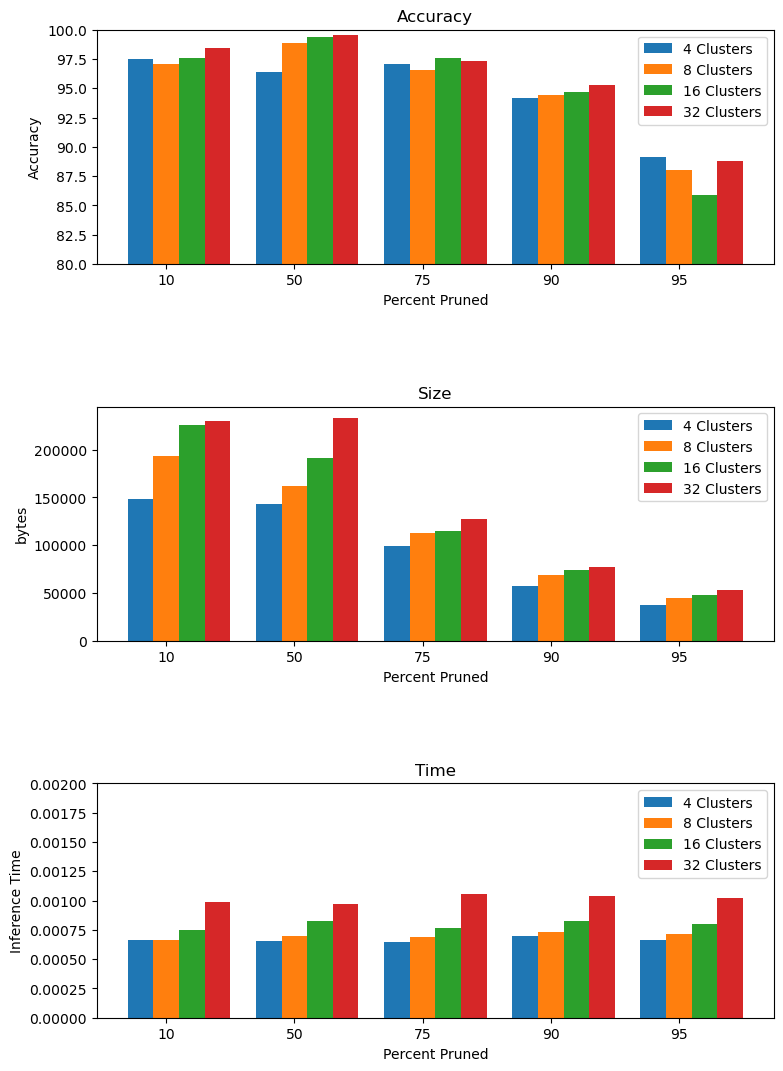

In [14]:
#graphing the data created in the cell above

#loading data
metrics = pd.read_csv("PruningClusteringCombos.csv")

#hidden x values and labels
val=[-0.2,0.8,1.8,2.8,3.8]
val2=[0.0,1.0,2.0,3.0,4.0]
val3=[0.2,1.2,2.2,3.2,4.2]
val4=[0.4,1.4,2.4,3.4,4.4]
text=['10','50','75','90','95']

#graphing
#main figure code
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.tight_layout(pad=2)
fig.set_size_inches(8, 12)

#accuracy over pruning and clustering combinations
ax1.bar(val, metrics.iloc[::4,2], label='4 Clusters', width=0.2)
ax1.bar(val2, metrics.iloc[1::4,2], label='8 Clusters', width=0.2)
ax1.bar(val3, metrics.iloc[2::4,2], label='16 Clusters', width=0.2)
ax1.bar(val4, metrics.iloc[3::4,2], label='32 Clusters', width=0.2)
ax1.set_title("Accuracy")
ax1.set_xlabel("Percent Pruned")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([80,100])
ax1.set_xticks(val2)
ax1.set_xticklabels(text)
ax1.legend()

#Size bar graphs
ax2.bar(val, metrics.iloc[::4,3], label='4 Clusters', width=0.2)
ax2.bar(val2, metrics.iloc[1::4,3], label='8 Clusters', width=0.2)
ax2.bar(val3, metrics.iloc[2::4,3], label='16 Clusters', width=0.2)
ax2.bar(val4, metrics.iloc[3::4,3], label='32 Clusters', width=0.2)
ax2.set_title("Size")
ax2.set_xlabel("Percent Pruned")
ax2.set_ylabel("bytes")
ax2.set_xticks(val2)
ax2.set_xticklabels(text)
ax2.legend()

#inference time bar graphs
ax3.bar(val, metrics.iloc[::4,4], label='4 Clusters', width=0.2)
ax3.bar(val2, metrics.iloc[1::4,4], label='8 Clusters', width=0.2)
ax3.bar(val3, metrics.iloc[2::4,4], label='16 Clusters', width=0.2)
ax3.bar(val4, metrics.iloc[3::4,4], label='32 Clusters', width=0.2)
ax3.set_title("Time")
ax3.set_xlabel("Percent Pruned")
ax3.set_ylabel("Inference Time")
ax3.set_xticks(val2)
ax3.set_xticklabels(text)
ax3.set_ylim([0,0.002])
ax3.legend()

Based upon the above graphs. We have determined that the model  with a cluster of 32 and a pruning of 90% is best. It minimizes size while still keeping a practically real time prediction and >95% accuracy.

# Final model metrics calculations

In [5]:
#loading the model
clusters = 32
final_sparsity = 0.9
model =  tf.keras.models.load_model(f'stripClust_signLang_model_{final_sparsity}_{clusters}.h5')

In [6]:
#re-compiling the model
model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [17]:
#getting loss and accuracy of model
loss, acc = model.evaluate(test_images, labels_test, verbose=2)

225/225 - 1s - loss: 0.3086 - accuracy: 0.9299 - 1s/epoch - 6ms/step


225/225 [==============================] - 1s 5ms/step


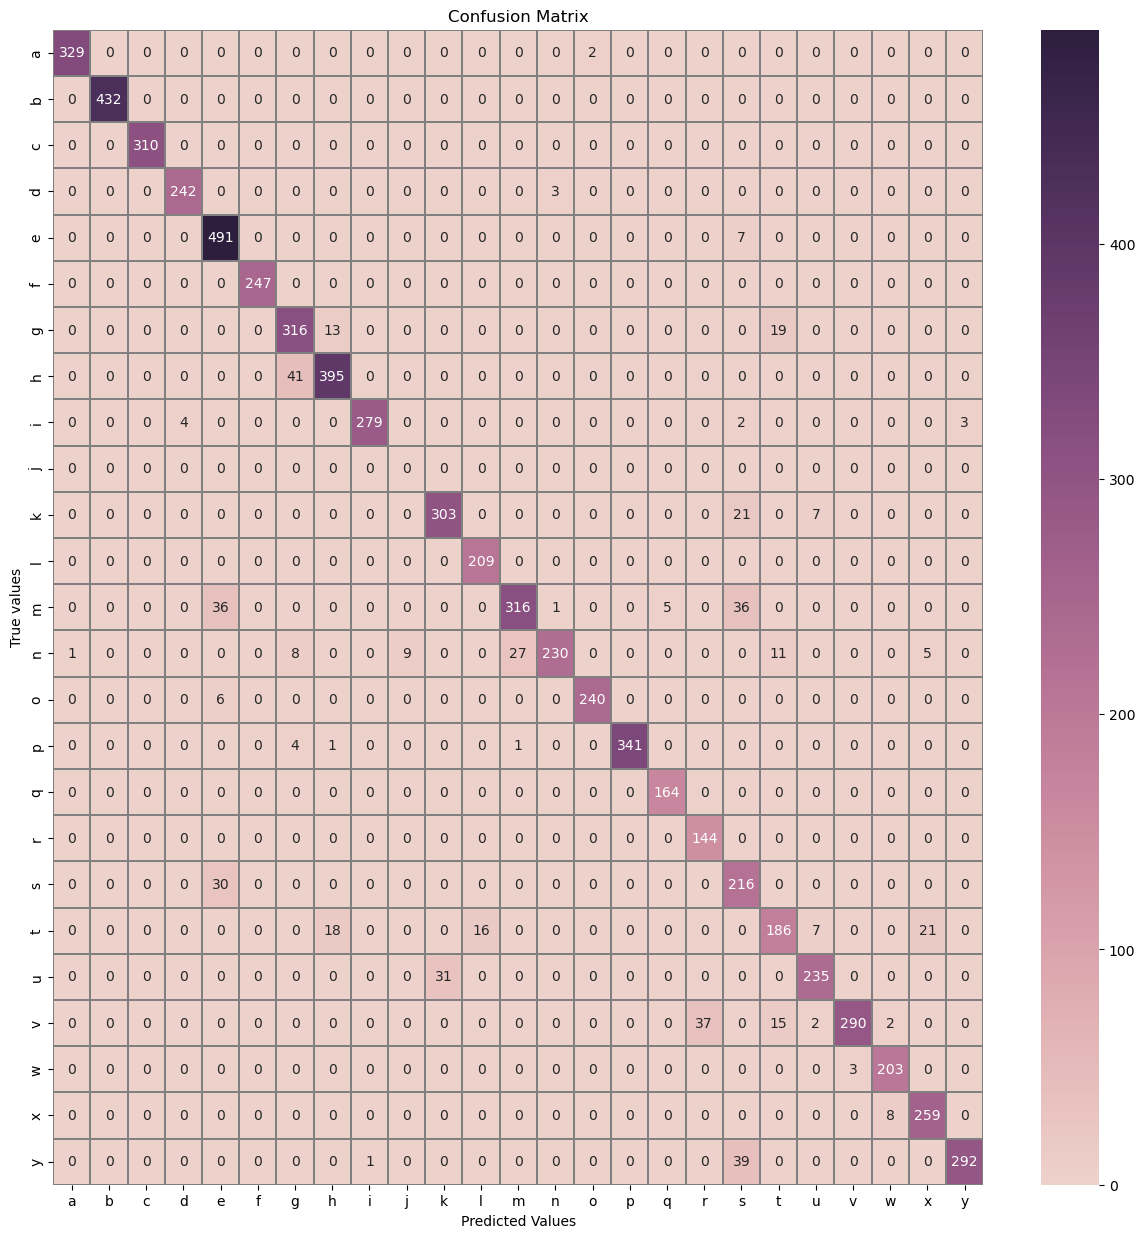

In [18]:
#creating confusion matrix
import seaborn as sns
from seaborn import heatmap

#generating data
predictions = model.predict(test_images)
data = tf.math.confusion_matrix(np.argmax(labels_test, axis=1), np.argmax(predictions, axis = 1))

#labels
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
ticks = np.arange(25)

#ploting code
fig, ax = plt.subplots(figsize=(15,15))
heatmap(data, cmap=sns.cubehelix_palette(as_cmap=True), linecolor="gray", linewidths=0.01, annot=True, ax=ax, fmt='.3g')
plt.xlabel("Predicted Values")
plt.ylabel("True values")
plt.xticks(ticks+0.5,labels=letters)
plt.yticks(ticks+0.5,labels=letters)
plt.title("Confusion Matrix")
plt.show()

In [19]:
# getting precision and recall
y_pred = model.predict(test_images)
predicted_classes = np.argmax(y_pred, axis=1)
class_labels = np.argmax(labels_test, axis=1)

#defining some varaiables to make the output nicer
letters = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
l = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

#getting precision and recall in convenient report
report = classification_report(class_labels,predicted_classes,labels=l,target_names=letters)

#printing results
print(report)

225/225 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           a       1.00      0.99      1.00       331
           b       1.00      1.00      1.00       432
           c       1.00      1.00      1.00       310
           d       0.98      0.99      0.99       245
           e       0.87      0.99      0.93       498
           f       1.00      1.00      1.00       247
           g       0.86      0.91      0.88       348
           h       0.93      0.91      0.92       436
           i       1.00      0.97      0.98       288
           k       0.91      0.92      0.91       331
           l       0.93      1.00      0.96       209
           m       0.92      0.80      0.86       394
           n       0.98      0.79      0.88       291
           o       0.99      0.98      0.98       246
           p       1.00      0.98      0.99       347
           q       0.97      1.00      0.98       164
           r       0.80   

225/225 [==============================] - 1s 5ms/step


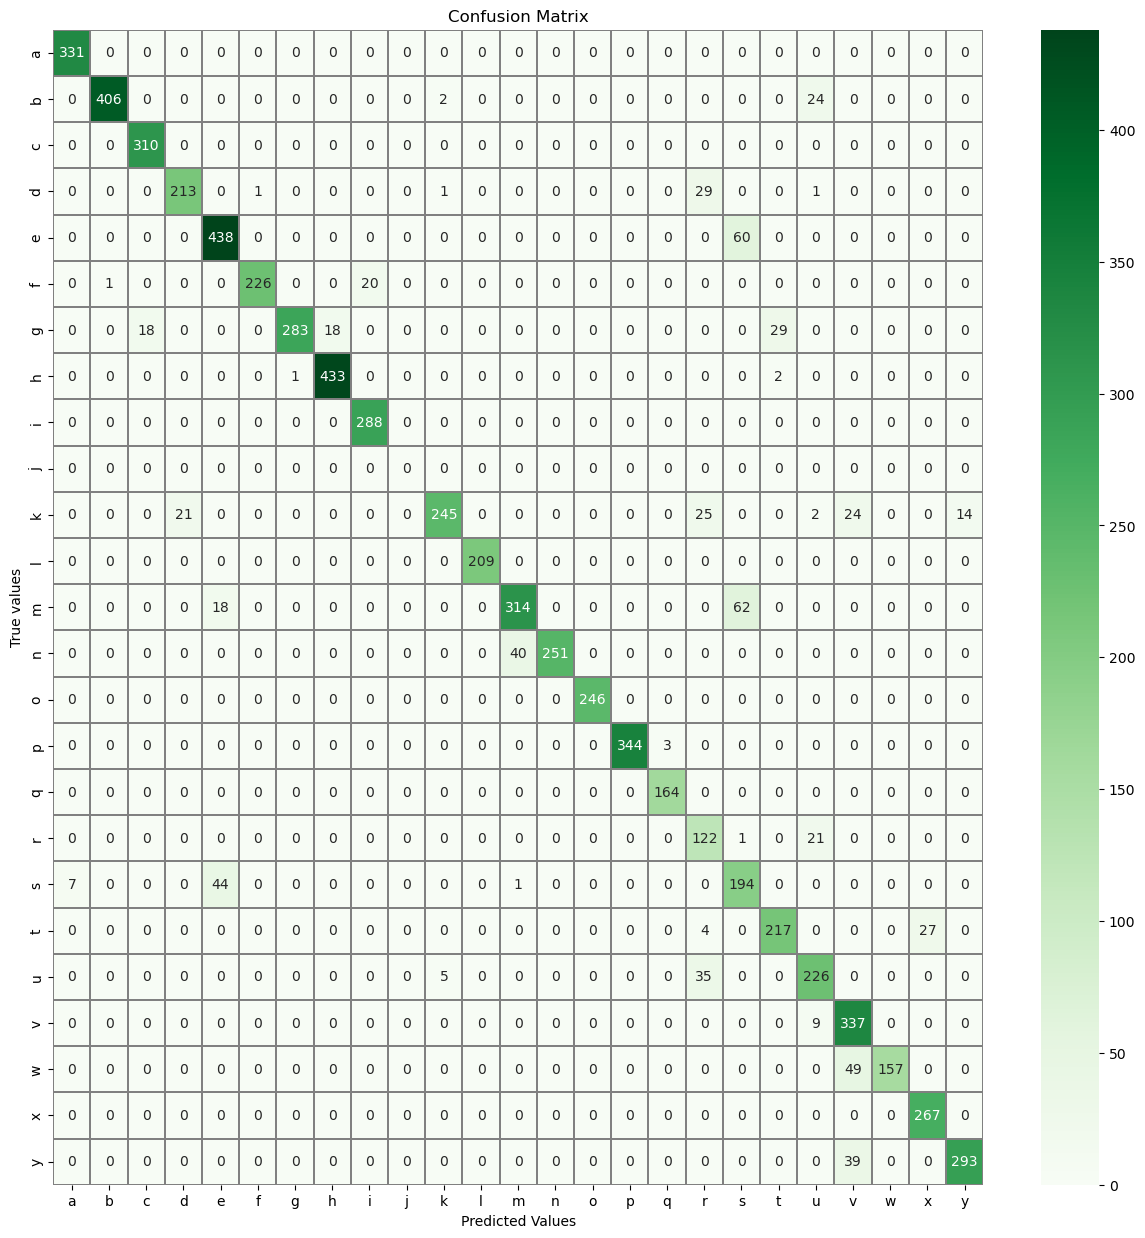

In [33]:
#base model conf mat for comparison
model =  tf.keras.models.load_model(f'trained_signLang_model.h5')


#generating data
predictions = model.predict(test_images)
data = tf.math.confusion_matrix(np.argmax(labels_test, axis=1), np.argmax(predictions, axis = 1))

#labels
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
ticks = np.arange(25)

#ploting code
fig, ax = plt.subplots(figsize=(15,15))
heatmap(data, cmap='Greens', linecolor="gray", linewidths=0.01, annot=True, ax=ax, fmt='.3g')
plt.xlabel("Predicted Values")
plt.ylabel("True values")
plt.xticks(ticks+0.5,labels=letters)
plt.yticks(ticks+0.5,labels=letters)
plt.title("Confusion Matrix")
plt.show()